In [0]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms 
from tqdm.notebook import  tqdm
from IPython.display import clear_output


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    AddGaussianNoise(mean = 0.5, std = 0.01),
])

train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms )

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 1000, shuffle = True)

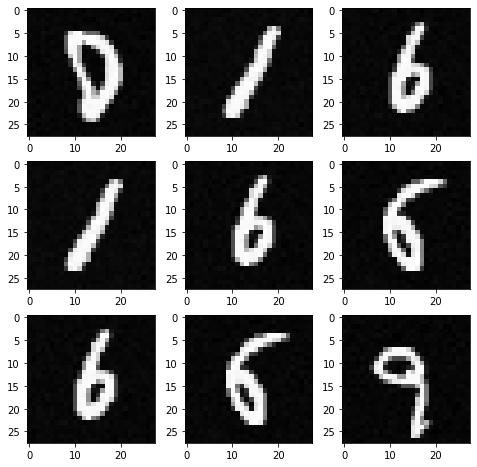

In [38]:
sample = next(iter(train_loader))
x, y = sample
x = x[:9]
fig, ax = plt.subplots(3,3, figsize = (8,8))
for m in range(3):
    for n in range(3):

        np_image = x[m+n].squeeze(0).detach().numpy()

        ax[m,n].imshow(np_image, cmap = "gray")

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28*28, 2*28*28),
            nn.ReLU(),
            nn.Linear(2*28*28, 28*28),
            nn.Sigmoid()
        ) 
        self.model.apply(init_weights)

    def forward(self, x):
        
        return self.model(x)

G = Net()
G_optim = optim.Adam(G.parameters(), lr = 0.00005)

In [0]:
class Net_dis(nn.Module):
    def __init__(self):
        super(Net_dis, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28*28, 2*28*28),
            nn.ReLU(),
            nn.Linear(2*28*28, 1),
            nn.Sigmoid()
        ) 
        self.model.apply(init_weights)


    def forward(self, x):
        

        return self.model(x)

D = Net_dis()
D_optim = optim.Adam(D.parameters(), lr = 0.00003)


In [0]:
noise = torch.randn([1,1, 1, 28*28])
answer = G(noise).squeeze(0).squeeze(0).view([28,28]).detach().numpy()

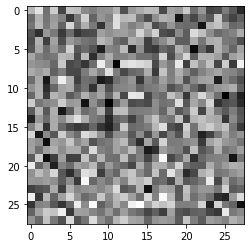

In [17]:
plt.imshow(answer, cmap = "gray")

In [0]:
def plot_all_losses(d_real_loss, d_fake_loss, g_loss_run):
    plt.plot(d_real_loss, label = "D-real-loss")
    plt.plot(d_fake_loss, label = "D-fake-loss")
    plt.plot(g_loss_run, label = "G-loss")
    plt.legend()
    plt.show()

def show_gen_sample(z,G):

    samples = G(z[0]).detach()
    samples = samples.view([28,28])
    sample = samples.numpy()
    plt.imshow(sample, cmap = "gray")
    plt.show()


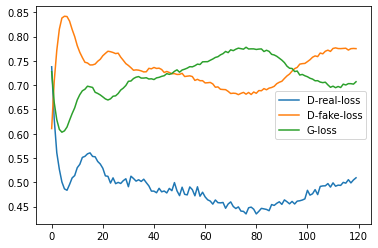

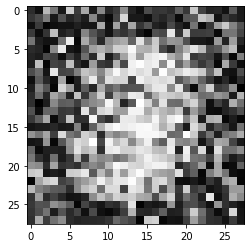

In [41]:
g_loss_run = []
d_real_loss_run = []
d_fake_loss_run = []


for epoch in range(2):
    

    for data in tqdm(train_loader):

        print("epoch ", epoch +1 )
        x, _ = data 

        nb_size = x.size(0)

        x = x.view(x.size(0), -1)

        one_labels = torch.ones(nb_size, 1)
        zero_labels = torch.zeros(nb_size, 1)

        z = torch.randn(nb_size, 28*28)
       

        G_sample = G(z)

        D_fake = D(G_sample)

        D_real = D(x)

        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)

        D_loss = D_fake_loss + D_real_loss

        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        z = torch.randn(nb_size, 28*28 )

        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss =  F.binary_cross_entropy(D_fake, one_labels)

        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

        g_loss_run.append(G_loss)
        d_real_loss_run.append(D_real_loss)
        d_fake_loss_run.append(D_fake_loss)

        clear_output(wait = True)

        plot_all_losses(d_real_loss_run, d_fake_loss_run, g_loss_run)
        
        show_gen_sample(z,G)

